In [2]:
import logging
import random
import multiprocessing

import incidence_graph
import incidence_mp
import multignn
import torch
import coloredlogs
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import graphutils
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

coloredlogs.install(level='INFO')
log = logging.getLogger(__name__)

multiprocessing.freeze_support()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log.info(f'Using device: {device}')

2022-12-17 23:13:15 lisplab1.thayer.dartmouth.edu __main__[513478] INFO Using device: cuda


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Create random graph

In [11]:
SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)

D = 256
V, E = 100, 1000
g = graphutils.plane(V, E, 2, 0.0, 10.0, lambda x, y: np.linalg.norm(x - y), 0.05)
#g.generalize(dimension=1, data_gen=np.mean)
# for tri, _ in incidence_graph.IncidenceGraphIterator(g, 2, 0):
#     a, b, c = g.get(tri[0]), g.get(tri[1]), g.get(tri[2])
#     g.put_simplex(tri, data=(a + b + c) / 3)
N = len(g)
print(f'{N} total nodes in graph')

dists, num_edges = graphutils.all_pairs_sp(g)
adj = torch.as_tensor(g.adjacency_matrices([0]), device=device)
A = adj.shape[0]
print('done')

Generating edges: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 24536.99it/s]


2385 total nodes in graph
done


In [12]:
x = torch.ones((N, 2), device=device)
for i, (vs, data) in enumerate(g):
    if len(vs) == 1:
        x[i] = torch.as_tensor(data)
    elif len(vs) >= 2:
        x[i, 0] = data

In [13]:
# TODO how to randomize batches?
# TODO how to generate "smarter" training pairs based on graph architecture?
train_size, train_batches = 256, 4
val_size = 512
all_pairs = [(i, j) for i in range(V) for j in range(i+1, V)]

random.shuffle(all_pairs)
train_pairs = all_pairs[:train_size * train_batches]
val_pairs = all_pairs[train_size * train_batches:train_size * train_batches+val_size]
test_pairs = all_pairs[train_size * train_batches+val_size:]

tr_mats = []
tr_ys = []
for b in range(train_batches):
    tr_mats.append(torch.zeros((train_size, V), device=device))
    tr_ys.append(torch.empty((train_size, ), device=device))
for e, (i, j) in enumerate(train_pairs):
    b, idx = e // train_size, e % train_size
    tr_mats[b][idx, i] = 1.0
    tr_mats[b][idx, j] = -1.0
    tr_ys[b][idx] = dists[i][j]

val_mat = torch.zeros((len(val_pairs), V), device=device)
val_y = torch.empty((len(val_pairs),), device=device)
for e, (i, j) in enumerate(val_pairs):
    val_mat[e, i] = 1.0
    val_mat[e, j] = -1.0
    val_y[e] = dists[i][j]

test_mat = torch.zeros((len(test_pairs), V), device=device)
test_y = torch.empty((len(test_pairs),), device=device)
for e, (i, j) in enumerate(test_pairs):
    test_mat[e, i] = 1.0
    test_mat[e, j] = -1.0
    test_y[e] = dists[i][j]

In [21]:
norm = 2
layer1 = multignn.MultiGraphLayer(transform_func=multignn.SegmentedTransform(2, D, g.shape(), activation_func=nn.ReLU()),
                                     graph_agg_func=multignn.LinearAggregate(A, D, nn.ReLU()),
                                     update_func=multignn.LinearMessageUpdate(D, nn.ReLU()),
                                     num_vertices=N)
layer2 = multignn.MultiGraphLayer(graph_agg_func=multignn.LinearAggregate(A, D, nn.ReLU()),
                                     update_func=multignn.LinearMessageUpdate(D, nn.ReLU()),
                                     num_vertices=N)
layer3 = multignn.MultiGraphLayer(graph_agg_func=multignn.LinearAggregate(A, D, nn.ReLU()),
                                     update_func=multignn.LinearMessageUpdate(D, nn.ReLU()),
                                     num_vertices=N)

# emb = torch.rand((N, D), device=device, requires_grad=True)
model = multignn.PartialForwardNN(layer1, layer2).to(device)

epochs = 5000
log_details = False
patience, threshold, start = 100, 1e-5, 0.75

opt = torch.optim.AdamW(model.parameters(), lr=0.0001)
#sched = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[1000, 2000, 3000, 4000, 5000, 5500], gamma=0.5)
s1 = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.2, patience=250)
#s2 = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[1000], gamma=0.5)
tr_losses = []
val_losses = []

it = range(epochs)
if not log_details:
    it = tqdm(it, desc='Training')

prev_loss = float('inf')
pc = patience
for e in it:
    avg_loss = 0.0
    for b in range(train_batches):
        output = model.forward(x, adj)[:V, :]
        opt.zero_grad()
        pred_dist = torch.linalg.norm(tr_mats[b] @ output, ord=norm, dim=1)
        diff = (pred_dist - tr_ys[b]) / train_size
        loss = (diff ** 2)
        # extra penalty for overestimates
        # loss += (F.relu(diff) ** 2)
        loss = torch.sum(loss) * train_size
        avg_loss += loss.item() / train_batches
        loss.backward()
        opt.step()
    tr_losses.append(avg_loss)

    output = model.forward(x, adj)[:V, :]
    pred_dist = torch.linalg.norm(val_mat @ output, ord=norm, dim=1)
    val_loss = torch.sum((pred_dist - val_y) ** 2 / len(val_pairs))
    val_losses.append(val_loss.item())
    if log_details:
        print(f'Epoch {e}: {avg_loss.item()} {val_loss.item()}')
    #s2.step()
    s1.step(val_loss)

    if e >= start * epochs:
        if abs(avg_loss - prev_loss) < threshold:
            pc -= 1
        else:
            pc = patience

    if pc == 0:
        print('Training concluded early due to stagnation')
        break
    prev_loss = avg_loss

print(f'Final train/val loss: {tr_losses[-1]}, {val_losses[-1]}')

Training:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 4455/5000 [02:03<00:15, 36.07it/s]

Training concluded early due to stagnation
Final train/val loss: 0.7411465644836426, 1.030928373336792


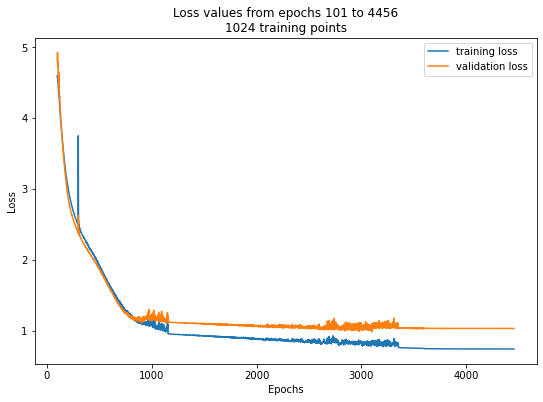

In [22]:
start=100
xs = list(range(start, len(tr_losses)))
plt.rcParams['figure.figsize'] = (9.0, 6.0)
plt.plot(xs, tr_losses[start:], label='training loss')
plt.plot(xs, val_losses[start:], label='validation loss')
#plt.yscale('log', base=16)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss values from epochs {start + 1} to {len(tr_losses)}\n'
          f'{train_size * train_batches} training points')
plt.legend()
plt.savefig('loss.png')
plt.show()

Loss: 7.24605131149292


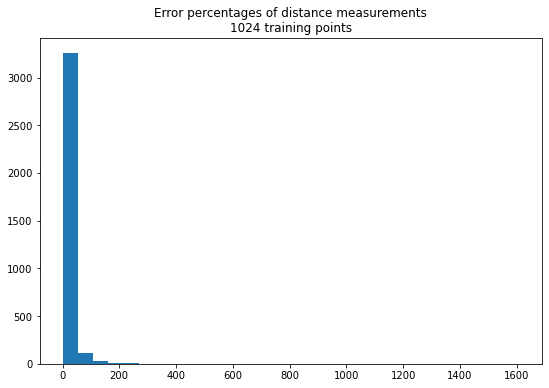

In [23]:
output = model.forward(x, adj)[:V, :]
pred_dist = torch.linalg.norm(test_mat @ output, ord=norm, dim=1)
diff = pred_dist - test_y
pred_loss = torch.sum(diff ** 2 / len(val_pairs))
errs = (abs(diff) / test_y) * 100
print(f'Loss: {pred_loss}')

output = output.cpu().detach().numpy()
errs = errs.cpu().detach().numpy()
_ = plt.hist(errs, bins=int(len(errs) ** (1/3) * 2 ))
plt.title(f'Error percentages of distance measurements\n{train_size * train_batches} training points')
plt.savefig('hist.png')
plt.show()

In [17]:
file = open('errs.txt', 'w')
for e in errs:
    file.write(f'{e}\n')
file.close()

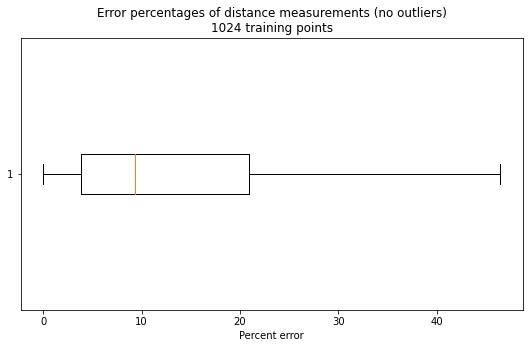

Num outliers: 220
Median: 9.327465534210205, Max: 46.43369674682617


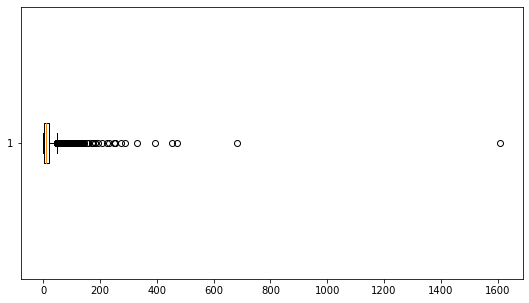

In [24]:
plt.rcParams['figure.figsize'] = (9.0, 5.0)
B = plt.boxplot(errs, vert=False, showfliers=False)
plt.title(f'Error percentages of distance measurements (no outliers)\n'
          f'{train_size * train_batches} training points')
plt.xlabel('Percent error')
plt.savefig('box.png')
plt.show()
B = plt.boxplot(errs, vert=False)
print(f'Num outliers: {len(B["fliers"][0].get_xydata())}')
print(f'Median: {B["medians"][0].get_xdata()[0]}, Max: {B["whiskers"][1].get_xdata()[1]}')

In [19]:
g_heur = graphutils.graph_heuristic(output, lambda x, y: np.linalg.norm(x - y, ord=norm))
d_heur = graphutils.dist_heuristic(lambda x, y: np.linalg.norm(x - y))
num_correct = 0
num_better = 0
num_equal = 0
pairs = [(i, j) for i in range(V) for j in range(i, V)]
for i, j in tqdm(pairs, desc='A-Star ranking test'):
    dist, ranks = graphutils.astar(g, i, j, g_heur)
    dist2, ranks2 = graphutils.astar(g, i, j, d_heur)
    if dist == dist2:
        num_correct += 1
        if ranks < ranks2:
            num_better += 1
        elif ranks == ranks2:
            num_equal += 1

print(f'Total accuracy: {num_correct / len(pairs)}')

A-Star ranking test: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5050/5050 [00:09<00:00, 560.19it/s]

Total accuracy: 0.6835643564356436


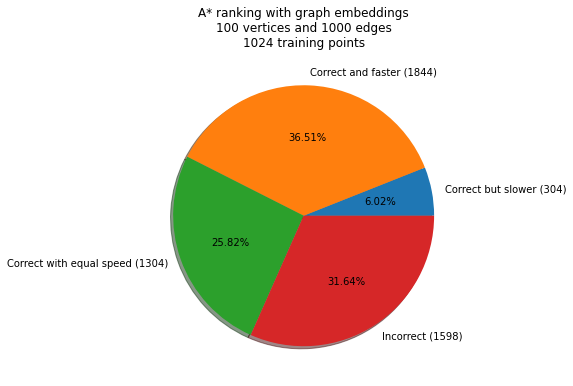

304 1844 1304 1598


In [20]:
plt.rcParams['figure.figsize'] = (9.0, 6.0)
_ = plt.pie([num_correct - num_better - num_equal, num_better, num_equal, len(pairs) - num_correct],
            labels=[f'Correct but slower ({num_correct - num_better - num_equal})', f'Correct and faster ({num_better})', f'Correct with equal speed ({num_equal})', f'Incorrect ({len(pairs) - num_correct})'],
            autopct='%0.2f%%', shadow=True)
plt.title(f'A* ranking with graph embeddings\n'
          f'{V} vertices and {E} edges\n'
          f'{train_size * train_batches} training points')
#plt.savefig('pie.png')
plt.show()
print(num_correct - num_better - num_equal, num_better, num_equal, len(pairs) - num_correct)

In [ ]:
"""


"""